# モデル全てを使ったファインチューニング
## データ拡張を行う特徴抽出

### たたみ込みベースに全結分類器を追加

In [1]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D,Input
import os.path,sys
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks
from keras.applications import VGG16
from keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import codecs
import pickle

N_CATEGORIES  = 20
IMAGE_SIZE = 256
BATCH_SIZE = 16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))



mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata.groupby("make_model"))

base_dir = 'mini_pictures'

train_dir = os.path.join(base_dir,'train')
valid_dir = os.path.join(base_dir,'valid')
test_dir = os.path.join(base_dir,'test')

Using TensorFlow backend.


In [2]:
from keras import models
from keras import layers
from keras.layers import Dense, GlobalAveragePooling2D,Input


pictures_files = os.listdir(train_dir)
NUM_TRAINING = 0
NUM_VALIDATION = 0
for i in range(classes_num):
    NUM_TRAINING += len(os.listdir(os.path.join(train_dir, pictures_files[i])))
    NUM_VALIDATION += len(os.listdir(os.path.join(valid_dir, pictures_files[i])))
print(NUM_TRAINING,NUM_VALIDATION)

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(N_CATEGORIES, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

1912 657


In [3]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

### VGG16の初期値を用いてモデル全体を訓練 

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

# 検証データは水増しするべきで無いことに注意
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,               #ターゲットディレクトリ
    target_size=(IMAGE_SIZE,IMAGE_SIZE),   #全ての画像を256*256に変換
    batch_size=BATCH_SIZE,           #バッチサイズ
    class_mode='categorical',#損失関数としてcategorical_crossentropyを使用するため,
    classes=classes          #他クラスラベルが必要
    )

validation_generator = test_datagen.flow_from_directory(
    valid_dir,               #ターゲットディレクトリ
    target_size=(IMAGE_SIZE,IMAGE_SIZE),   #全ての画像を256*256に変換
    batch_size=BATCH_SIZE,           #バッチサイズ
    class_mode='categorical',#損失関数としてcategorical_crossentropyを使用するため,
    classes=classes          #他クラスラベルが必要
    )

model.compile(optimizer=optimizers.Adam(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=NUM_VALIDATION//BATCH_SIZE,
    verbose=1
)


Found 1912 images belonging to 20 classes.
Found 657 images belonging to 20 classes.
Epoch 1/30
119/119 [==============================] - 5931s 50s/step - loss: 2.6214 - acc: 0.2009 - val_loss: 1.8030 - val_acc: 0.4588
Epoch 2/30
119/119 [==============================] - 5654s 48s/step - loss: 0.9055 - acc: 0.7184 - val_loss: 0.6224 - val_acc: 0.8736
Epoch 3/30
119/119 [==============================] - 5655s 48s/step - loss: 0.2723 - acc: 0.9167 - val_loss: 0.2358 - val_acc: 0.9345
Epoch 4/30
119/119 [==============================] - 5651s 47s/step - loss: 0.1147 - acc: 0.9668 - val_loss: 0.0754 - val_acc: 0.9516
Epoch 5/30
119/119 [==============================] - 5637s 47s/step - loss: 0.0988 - acc: 0.9778 - val_loss: 0.0614 - val_acc: 0.9922
Epoch 6/30
119/119 [==============================] - 5627s 47s/step - loss: 0.0093 - acc: 0.9995 - val_loss: 0.1244 - val_acc: 0.9906
Epoch 7/30
119/119 [==============================] - 6356s 53s/step - loss: 0.0019 - acc: 1.0000 - val_l

In [17]:
with open('histories/history_VGG16_mini_extended_2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

model.save('models/VGG16_mini_extended_2.h5')

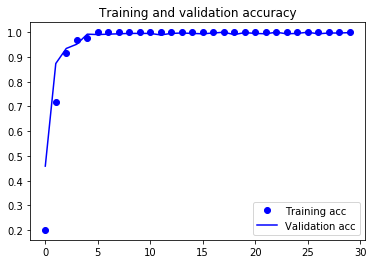

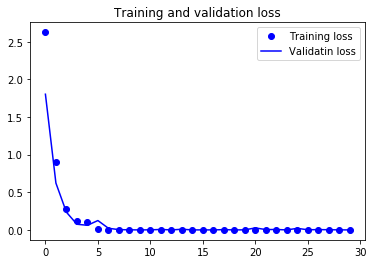

In [22]:
f = codecs.open('histories/history_VGG16_mini_extended_2.pkl', 'r','utf-8', 'ignore')
history = pickle.load(f)
f.close()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
f_mdoel = models.load_model('models/VGG16_mini_extended_2.h5')
f_mdoel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

## 車に特化したたたみ込み層を作成し、その後、さらに追加で後半の部分と分類器を追加学習させる  

* 訓練済みベースネットワークの最後にカスタムネットワークを追加する
* ベースネットワークを凍結する
* 追加した部分の訓練を行う
* ベースネットワークの一部を解凍する
* 凍結した層と追加した部分の訓練を同時に行う

上で３つ目までが終わっているので、４の、たたみ込みベース(conv_base)を解凍し、その中に含まれる層を個別に凍結する

### ファインチューニングを行うのは最後の２つか３つの層のみ!
つまり、block4_poolまでの層は全て凍結される。

block5_conv1,block5_conv2,block5_conv3の３つの層が訓練可能になる

In [25]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),#学習率が低いのはファインチューニングを行う３つの層の変更を制限するため
             loss='categorical_crossentropy',
             metrics=['acc'])

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [28]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=NUM_VALIDATION//BATCH_SIZE)

Epoch 1/30
119/119 [==============================] - 2573s 22s/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0243 - val_acc: 0.9970
Epoch 2/30
119/119 [==============================] - 2441s 21s/step - loss: 5.2417e-05 - acc: 1.0000 - val_loss: 1.2466e-04 - val_acc: 0.9969
Epoch 3/30
119/119 [==============================] - 1825s 15s/step - loss: 3.8532e-05 - acc: 1.0000 - val_loss: 4.0005e-04 - val_acc: 0.9969
Epoch 4/30
119/119 [==============================] - 1334s 11s/step - loss: 3.2523e-05 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9938
Epoch 5/30
119/119 [==============================] - 1252s 11s/step - loss: 2.9230e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 0.9953
Epoch 6/30
119/119 [==============================] - 1212s 10s/step - loss: 2.5697e-05 - acc: 1.0000 - val_loss: 9.9907e-04 - val_acc: 0.9969
Epoch 7/30
119/119 [==============================] - 1210s 10s/step - loss: 2.4115e-05 - acc: 1.0000 - val_loss: 5.1985e-04 - val_acc: 0.9953
Epoch 8/30
119/

In [30]:
with open('histories/history_VGG16_mini_extended_fine2.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    
model.save('models/VGG16_mini_extended_fine2.h5')

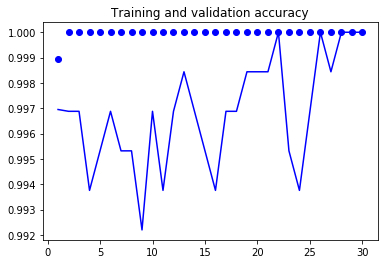

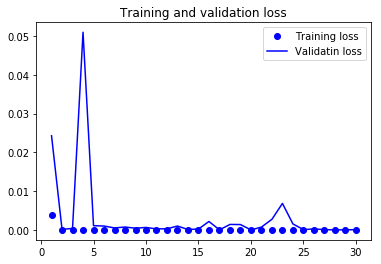

In [31]:
%matplotlib inline
f = codecs.open('histories/history_VGG16_mini_extended_fine2.pkl', 'r','utf-8', 'ignore')
history = pickle.load(f)
f.close()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()